In [410]:
import torch
import numpy as np

In [411]:
model = torch.jit.load("../models/eigenvectors_cosine_similarity_skip1_batch64_modelstandard_actelu.pt")
model.eval()

RecursiveScriptModule(
  original_name=Model
  (conv1): RecursiveScriptModule(original_name=Conv2d)
  (conv2): RecursiveScriptModule(original_name=Conv2d)
  (conv3): RecursiveScriptModule(original_name=Conv2d)
  (conv4): RecursiveScriptModule(original_name=Conv2d)
  (conv5): RecursiveScriptModule(original_name=Conv2d)
  (conv6): RecursiveScriptModule(original_name=Conv2d)
  (conv7): RecursiveScriptModule(original_name=Conv2d)
  (conv8): RecursiveScriptModule(original_name=Conv2d)
  (conv9): RecursiveScriptModule(original_name=Conv2d)
  (conv10): RecursiveScriptModule(original_name=Conv2d)
  (conv11): RecursiveScriptModule(original_name=Conv2d)
  (conv12): RecursiveScriptModule(original_name=Conv2d)
  (reduce_channels): RecursiveScriptModule(original_name=Conv2d)
  (avgpool): RecursiveScriptModule(original_name=AvgPool2d)
  (act): RecursiveScriptModule(original_name=ELU)
)

In [412]:
residual_vectors = []
for i in range(0, 100):
    # random tensor of shape (1, 34, 34)
    residual_vector = torch.randn(1, 34, 34)
    residual_vectors.append(residual_vector)

residual_vectors = np.array(residual_vectors)
residual_vectors = torch.tensor(residual_vectors).float().to("cuda")

In [413]:
outputs = model(residual_vectors)

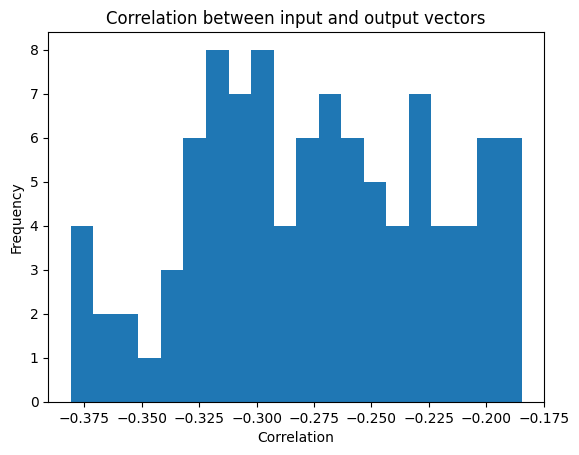

In [415]:
# histogram of correlations
import matplotlib.pyplot as plt
plt.hist(correlations, bins=20)
plt.xlabel("Correlation")
plt.ylabel("Frequency")
plt.title("Correlation between input and output vectors")
plt.show()

In [416]:
correlations
mean = np.mean(correlations)
median = np.median(correlations)
Q5 = np.percentile(correlations, 5)
Q1 = np.percentile(correlations, 25)
Q3 = np.percentile(correlations, 75)
Q95 = np.percentile(correlations, 95)
std = np.std(correlations)
print(f"Mean: {mean}, Std: {std}, Median: {median}, Q1: {Q1}, Q3: {Q3}, Q5: {Q5}, Q95: {Q95}")

Mean: -0.2745591104030609, Std: 0.05163177475333214, Median: -0.27940332889556885, Q1: -0.3135024681687355, Q3: -0.23233608901500702, Q5: -0.36821834146976473, Q95: -0.19224052354693413


In [417]:
grid_size_x = 34
grid_size_y = 34
dx = 1 / (grid_size_x)
dy = 1 / (grid_size_y)
dx2 = dx ** 2
dy2 = dy ** 2

# generate Matrix A which is the discretized Laplacian in 2D
A = np.zeros((grid_size_x * grid_size_y, grid_size_x * grid_size_y))
for i in range(grid_size_x):
    for j in range(grid_size_y):
        row = i * grid_size_y + j
        A[row, row] = -2 * (1 / dx2 + 1 / dy2)
        if i > 0:
            A[row, row - grid_size_y] = 1 / dx2
        if i < grid_size_x - 1:
            A[row, row + grid_size_y] = 1 / dx2
        if j > 0:
            A[row, row - 1] = 1 / dy2
        if j < grid_size_y - 1:
            A[row, row + 1] = 1 / dy2

A_inverse = np.linalg.inv(A)

In [418]:
correlations = []
input_vectors = []
output_vectors = []

for i in range(0, 100):
    input_vector = residual_vectors[i].reshape(1, -1).squeeze(0)
    output_vector = A_inverse @ input_vector.cpu().detach().numpy()
    input_vectors.append(input_vector.cpu().detach().numpy())
    output_vectors.append(output_vector)
    output_vector = torch.tensor(output_vector).float().to("cuda")
    correlation = torch.nn.functional.cosine_similarity(input_vector, output_vector, dim=0).cpu().detach().numpy()
    correlations.append(correlation)

In [419]:
correlations
mean = np.mean(correlations)
median = np.median(correlations)
Q1 = np.percentile(correlations, 25)
Q3 = np.percentile(correlations, 75)
std = np.std(correlations)
print(f"Mean: {mean}, Std: {std}, Median: {median}, Q1: {Q1}, Q3: {Q3}")

Mean: -0.2767992913722992, Std: 0.06179283186793327, Median: -0.28218725323677063, Q1: -0.322615385055542, Q3: -0.22732162848114967


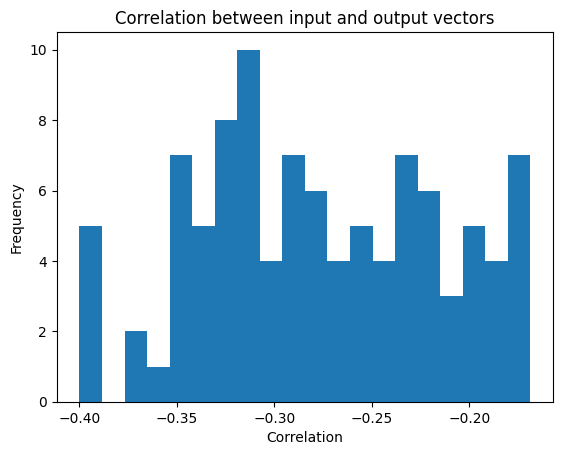

In [420]:
# histogram of correlations
import matplotlib.pyplot as plt
plt.hist(correlations, bins=20)
plt.xlabel("Correlation")
plt.ylabel("Frequency")
plt.title("Correlation between input and output vectors")
plt.show()